> # Gradient Problem #

In model training step, we will face vanishing or exploding gradient. This means gradient is getting smaller or bigger as we go lower layer. These problrms makes model not be trained well. 

One reason is activation function. For example, differential value of sigmoid activation function is between 0 and 1. As input value is getting bigger to positive or negative, the gradient goes close to 0. So when backpropagation algorithm works, model can't train well since there are little gradient to send.

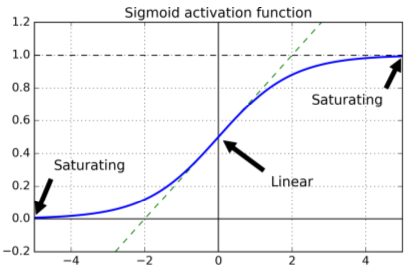

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import warnings; warnings.filterwarnings("ignore")

- ### Glorot and He Initialization. ###

There is a thesis that suggest a way to alletive gradient problem. Bidirectional(forward in prediction, backward in backpropagation) signal should flow properly. Researchers said variances of ouput and input in each layer should be same. And Gradient variance before and after passing through layer should same. In fact if numbers of input and output(called fan-in and fan-out) connection are not same, we can't assure two conditions. But there is an alternative. It is to randomly initialize connection weight of each layer to blow fomular. This is called Glorot initialization.

$ fan_{avg} = (fan_{in}+fan_{out})\ / \ 2 $

$ \mathsf{A\ normal\ distribution} \quad avg=0,\ variance=\frac{1}{fan_{avg}} $
$ \mathsf{Or\ a\ uniform\ distribution\ between} \quad -r\ and\ +r, \ r=\sqrt{\frac{1}{fan_{avg}}}$

If we change $fan_{avg}$ to $fan_{in}$, it is called LuCun initialization. 

Other theses suggested similar strategy about other activation function. Initialization strategy about ReLU function is called He initialization. And we should use LuCun initialization for SELU function.

Keras basically uses Glorot initialization. We can use He initialization by **he_uniform** or **he_normal**.

In [2]:
keras.layers.Dense(10, activation='relu', kernel_initializer="he_normal")

If we want to use uniform distribution He initialization, we can use VarianceSclaing like below.

In [3]:
he_avg_init = keras.initializers.VarianceScaling(scale=2, mode='fan_avg', distribution='uniform')
keras.layers.Dense(10, activation='sigmoid', kernel_initializer=he_avg_init)

In previous, we thought that sigmoid function is the best choice. But, other activation functions work better in DNN. Specially ReLU has a big advantage that it doesn't converge certain value. However ReLU is not perfect. Dying Lelu problem can happen. When it occurs, some neurons print only 0 value. Especially half of neurons dies if we use big learning rate. It happens when weights of nerons is changed and sum of weights becomes negative about all samples.

To solve this problem we use variety of ReLU like LeakyReLU.

$ \mathsf{LeakyReLU_\alpha}(z)=max(\alpha z,z)$

Generally $\alpha$ is setted 0.01. This makes LeakyLeRU not to die. A neuron can falls into a coma but it has probability of waking up again. RReLU(choose $\alpha$ randomly in given area) also works well. And PReLU($\alpha$ is trained during train step) works well in huge dataset. But overfitting danger is in small data.

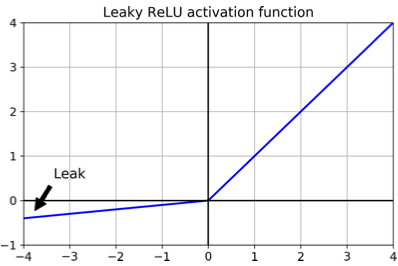

And ELU function is suggested. This function's performance outstrips other ReLU varieties in experiment.

$ \mathsf{ELU_\alpha}(z) =  \alpha(\mathsf{exp}(z)-1) \quad in \ z<0$

$ \mathsf{ELU_\alpha}(z) =  z \quad in \ z\geq 0$

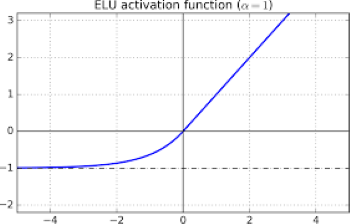

Since neagative value incomes when z < 0, mean output of activation function is closed to 0. This minigates vanishing gradient. Hyperparameter $\alpha$ sets a value that converges to when z is a large negative value. And gradient never becomes 0, so it doesn't make dead neuron. Major disadvantage of avtivation function is that calculation of ELU is slower than other ReLU family. Although convergence speed is quick in training step, ELU is slower than ReLU in test set. 

And there is SELU function which is variety of ELU. Reasearcher said if we make neural network using fully connected layers and use SELU function, the network seems to be self-normalized. Output of each layer is maintained 0 mean and 1 variance. This blocks vanishing and exploding gradient. But there are some conditions to make self-normalize happen. 1. Inout feature should be standatdizaiton(0 mean, 1 standard deviation). 2. Weights of all hidden layers should be initialized by LuCun initialization. 3. Network should be composed in a rows of layers.

To use LeakyReLU, make LeakyReLU layer and add to layer want to apply.

In [4]:
model = keras.models.Sequential([
    keras.layers.Dense(10, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(alpha=0.2)
])

To use SELU, some settings need.

In [5]:
layer = keras.layers.Dense(10, activation='selu', kernel_initializer='lecun_normal')

- ### Batch Normalization ###

Some activation functions reduce probability of vanishing or exploding gradient in the beginning of training. But there is no guarantee it doesn't occur again.

And some researchers suggest batch normalization. This method add an operation before or after passing activation function at each layer. This operation sets inputs at the origin and normalizes it. Then adjusts scale of outputs and moves in each layer by two new parameters. One is used for adjusting scale and the other is used for moving. If we add batch normalization at first layer, we don't need to do normalization.

For normalization, algorithm should estimate mean and variation.

- $\mu_B=\frac{1}{m_B}\sum_{m_B}^{i=1}\mathbf{x^{i}} \quad \quad $      

- $\sigma_B ^2 = \frac{1}{m_B}\sum_{m_B}^{i=1}(\mathbf{x^{i}}-\mu_B)^2 \quad \quad$ 

- $\hat{\mathbf{x}}^i = \frac{\mathbf{x}^i-\mu_B}{\sqrt{\sigma_B^2+\epsilon}}$

- $z^i=\gamma\otimes\hat{\mathbf{x}}^i+\beta$

$\mu_B$ is mean vector of input about mini batch B. $\sigma_B$ is standard deviation vector about mini batch B. $m_B$ is number of samples in minibatch. $\hat{\mathbf{x}}^i$ is input of normalized sample whose mean is 0. $\gamma$ is output scale parameter vector of layer. $\otimes$ is element-wise-multiplication. $\beta$ is output move parameter vector of layer. Each input moves as much as the parmeters. $\epsilon$ is a little number to prevent denominator becomes 0. $z^i$ is output of minibatch normalization operation.

In test set, there is mo way to calculate mean and std of input. One way is to calculate mean and std about each input of mini batch layer by passing all train set through network. And at prediction, we can use this final mean and std values as batch input mean and std. 

$\gamma$(output scale vector) and $\beta$(output moving vector) are trained through general backpropagation. And $\mu$(final input mean vector) and $\sigma$(final input std vector) are estimated by exponential moving average.

And batch normalization also makes regularization.

But it increases complexity of model. And added operations makes prediction of model slow down. However we can avoid it by composing previous layer and batch normalizing layer after train step.

Batch normalization is represented by keras so easily. Just add **BatchNormalization** layer before or after activation function of hidden layer.

In [6]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation='elu', kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation='softmax')
])

In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_4 (Dense)              (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_5 (Dense)              (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_6 (Dense)              (None, 10)               

Batch normalization layer adds $\gamma,\ \beta,\ \mu,\ \sigma$. So there are 3136(4X784) parameters in first batch layer. Last two parameters $\mu,\ \sigma$ are moving average. Since they are not trained by backpropagation, it is classified Non-trainable parameter. And if we want to add batch normalizaion layer before activation function, we have to add activation function after batch layer. Since batch layer includes moving parameter, we can except bias at previous layer.

In [10]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, kernel_initializer='he_normal', use_bias=False),
    keras.layers.Activation('elu'),
    keras.layers.Dense(100, kernel_initializer='he_normal', use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('elu'),
    keras.layers.Dense(10, activation='softmax')
])

There are **momentum**, **axis** hyperparameters. In some cases, we have to change **momentum** variable. Batchnormalization layer uses it when updating exponential moving average. When new $\mathsf{v}$ is given, it updates moving average $\hat{\mathsf{v}}$ by under fomular.

$\hat{\mathsf{v}} \leftarrow \hat{\mathsf{v}} \times momentum\ + \ \mathsf{v} \times (1-momentum)$

And **axis** decides axis to normalize

- ### Gradient clipping ###

One popular way to miligate exploding gradient is to cut gradient not to overcome certain threshold.

In [12]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss='mse', optimizer=optimizer)

This optimizer clips all elements of gradient vector between -1 and 1. So it changes direction of gradient vector. If origin gradient vector is [0.9, 100.0], it heads second axis. But when clips it to [0.9, 1.0], it heads diagonal direction. If we want not to change direction, set **clipnorm** instead **clipvalue**. Then in above example, the vector changed to [0.00899, 0.99101]. We can use both value and norm in clipping. Then check what method makes best performance.